<a href="https://colab.research.google.com/github/TREND-tut/TREND/blob/master/TRENDreservoir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/TREND-tut/TREND.git

Cloning into 'TREND'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [0]:
%run TREND/reservoir.py
%run TREND/lorenz.py

In [0]:
import matplotlib.pyplot as plt
import scipy

In [0]:
ModelParams = Model() 
ModelParams.a = 10
ModelParams.b = 28
ModelParams.c = 8.0/3.0;
ModelParams.tau = 0.05
ModelParams.nstep = 20000

np.random.seed(1)

init_cond  = np.random.normal(0, 1, (3,))
generateddata = rk_lorenz_solve(init_cond, ModelParams)[:,1000:]

Text(0.5, 1.0, 'Lorenz Model Time Series')

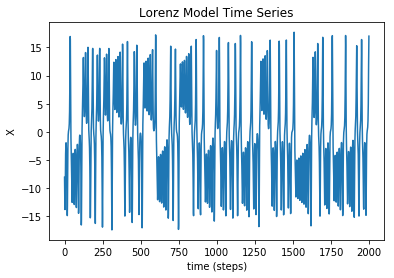

In [0]:
noise_scale = 0.01
generateddata = generateddata + np.random.normal(0, noise_scale, generateddata.shape)
data = np.zeros((3, generateddata.shape[1]))
data = generateddata
num_inputs = data.shape[0]

plt.plot(data[0, 0:1999])
plt.xlabel('time (steps)')
plt.ylabel('X')
plt.title('Lorenz Model Time Series')

Text(0.5, 1.0, 'Lorenz Model Time Series')

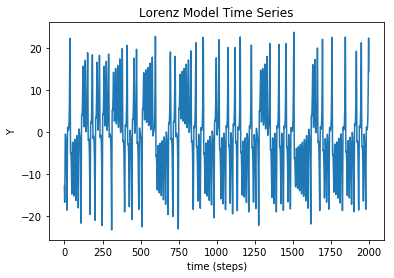

In [0]:
plt.plot(data[1, 0:1999])
plt.xlabel('time (steps)')
plt.ylabel('Y')
plt.title('Lorenz Model Time Series')

Text(0.5, 1.0, 'Lorenz Model Time Series')

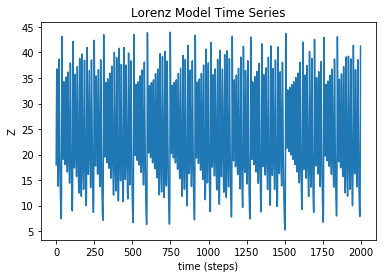

In [0]:
plt.plot(data[2, 0:1999])
plt.xlabel('time (steps)')
plt.ylabel('Z')
plt.title('Lorenz Model Time Series')

In [0]:
resparams = reservoir_parameters()
resparams.radius = 0.6
resparams.degree = 3
approx_res_size = 3000
resparams.N = int(np.floor(approx_res_size/num_inputs)*num_inputs)
resparams.sigma = 0.1
resparams.train_length = 10000
resparams.num_inputs = num_inputs;
resparams.predict_length = 5000
resparams.beta = 0.0001

In [0]:
A = generate_reservoir(resparams.N, resparams.radius, resparams.degree)

win = generate_input_layer(resparams)

In [0]:
states = np.zeros((resparams.N, resparams.train_length))

for i in range(resparams.train_length - 1):
  states[:,i+1] = np.tanh(A.dot(states[:,i]) + np.dot(win,data[:,i]))

r = states[:, resparams.train_length-1]


In [0]:
X = states
y = data[:, :resparams.train_length]
idenmat = np.eye(resparams.N)

In [0]:
w_out = np.dot(np.dot(y, X.T), scipy.linalg.pinv2(np.dot(X, X.T) + resparams.beta*idenmat)).reshape(3,-1)

In [0]:
r = states[:, resparams.train_length-1]

predictions = np.zeros((3, resparams.predict_length))

for t in range(resparams.predict_length -1):
	out = np.dot(w_out, r)
	r = np.tanh(A.dot(r) + np.dot(win,out))
	predictions[:, t] = out

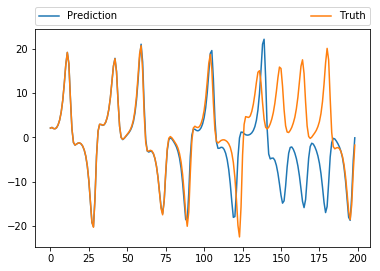

In [0]:
plt.plot(predictions.T[1:200,1], label= 'Prediction')
plt.plot(data[1, resparams.train_length:resparams.train_length+200-1],  label = 'Truth')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

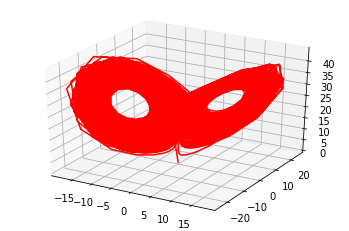

In [0]:
from mpl_toolkits import mplot3d

%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
xline = predictions.T[1:,0]
yline = predictions.T[1:,1]
zline = predictions.T[1:,2]
ax.plot3D(xline, yline, zline, 'r')



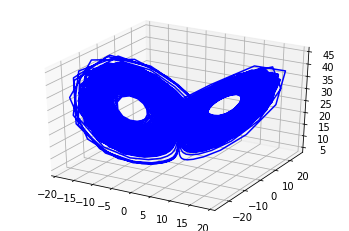

In [0]:
compare = data[:, resparams.train_length:resparams.train_length+resparams.predict_length-1]


fig = plt.figure()
ax = plt.axes(projection='3d')
xline = compare.T[1:,0]
yline = compare.T[1:,1]
zline = compare.T[1:,2]
ax.plot3D(xline, yline, zline, 'blue')